<a href="https://colab.research.google.com/github/AnaghaTantry/MIT-Internship/blob/main/USAirlinesDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# mount the Google drive to access the datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# uncomment and install, if necessary

#!pip install vaderSentiment    # install vader sentiment package
#!pip install textblob          # install textblob package
!pip install contractions      # install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 10.5 MB/s eta 0:00:00


In [ ]:
#import libraries below
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter                                                 # counter for key-value pairs in an object

import re, string, unicodedata                                                  # import text preprocessing libraries
import contractions                                                             # import contractions library
from bs4 import BeautifulSoup                                                   # import BeautifulSoup

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator                 # import wordcloud of a corpus, stopwords
import nltk                                                                     # import nltk library
from nltk.corpus import stopwords                                               # import nltk stopwords
from nltk.tokenize import word_tokenize, sent_tokenize                          # import Tokenizer
from nltk.stem.wordnet import WordNetLemmatizer                                 # import Lemmatizer
from nltk.stem.porter import PorterStemmer                                      # import Stemmer

from sklearn.feature_extraction.text import CountVectorizer                     # import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer                     # import TF-IDF

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold , StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier                             # import Random Forest Classifier
from sklearn.metrics import classification_report                               # import classification report
from sklearn.model_selection import cross_val_score

# download stopwords
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')

# format numeric data for easier readability
pd.set_option(
    "display.float_format", lambda x: "%.2f" % x
)  # to display numbers rounded to 2 decimal places

In [ ]:
# load the dataset of tweets
path1 = "/content/drive/MyDrive/Tweets.csv"
tweets = pd.read_csv(path1)
# create copy of dataset
df = tweets.copy()

In [ ]:
#Data cleaning
# convert all columns with dtype object into category to save memory
for col in df.columns[df.dtypes=='object']:
    df[col] = df[col].astype('category')

In [ ]:
# convert tweet_id into a category to save memory
df['tweet_id'] = df['tweet_id'].astype('category')

In [ ]:
# Convert tweet_created into a datetime to allow for time series analysis
df['tweet_created'] = pd.to_datetime(df['tweet_created'])

# Remove timezone information if it's timezone-aware
df['tweet_created'] = df['tweet_created'].dt.tz_localize(None)

# Now the column should be in datetime64[ns] format
print(df['tweet_created'].dtype)  # This should output: datetime64[ns]


datetime64[ns]


In [ ]:
# show summary of dataset after conversion
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   tweet_id                      14640 non-null  category      
 1   airline_sentiment             14640 non-null  category      
 2   airline_sentiment_confidence  14640 non-null  float64       
 3   negativereason                9178 non-null   category      
 4   negativereason_confidence     10522 non-null  float64       
 5   airline                       14640 non-null  category      
 6   airline_sentiment_gold        40 non-null     category      
 7   name                          14640 non-null  category      
 8   negativereason_gold           32 non-null     category      
 9   retweet_count                 14640 non-null  int64         
 10  text                          14640 non-null  category      
 11  tweet_coord                 

In [ ]:
#Exploratory data analysis (EDA)
#Numerical variables
df.describe().T

,count,mean,min,25%,50%,75%,max,std
airline_sentiment_confidence,14640.00,0.90,0.34,0.69,1.00,1.00,1.00,0.16
negativereason_confidence,10522.00,0.64,0.00,0.36,0.67,1.00,1.00,0.33
retweet_count,14640.00,0.08,0.00,0.00,0.00,0.00,44.00,0.75
tweet_created,14640,2015-02-21 11:33:24.781216,2015-02-16 23:36:05,2015-02-19 15:54:05.750000128,2015-02-22 04:44:35.500000,2015-02-23 08:04:11,2015-02-24 11:53:37,NaN


In [ ]:
#Categorical variables
df.describe(include=['category']).T
#During the period, the user with the maximum number of tweets, JetBlueNews, tweeted 32 times (~5 tweets/per day)

,count,unique,top,freq
tweet_id,14640,14485,570281470507352064,2
airline_sentiment,14640,3,negative,9178
negativereason,9178,10,Customer Service Issue,2910
airline,14640,6,United,3822
airline_sentiment_gold,40,3,negative,32
name,14640,7701,JetBlueNews,63
negativereason_gold,32,13,Customer Service Issue,12
text,14640,14427,@united thanks,6
tweet_coord,1019,832,"[0.0, 0.0]",164
tweet_location,9907,3081,"Boston, MA",157


In [ ]:
#Datetime variables
# show summary of datetime variable
df.describe(include=['datetime']).T

,count,mean,min,25%,50%,75%,max
tweet_created,14640,2015-02-21 11:33:24.781216,2015-02-16 23:36:05,2015-02-19 15:54:05.750000128,2015-02-22 04:44:35.500,2015-02-23 08:04:11,2015-02-24 11:53:37


In [ ]:
#Number of tweets by day
# show number of tweets by day
by_date = df.groupby(pd.Grouper(key='tweet_created', axis=0, freq='D')).count()['tweet_id']
print(by_date)
#February 23rd, a Monday, was the day with the most tweets
#February 17th, a Tuesday, was the day with the fewest tweet

tweet_created
2015-02-16       4
2015-02-17    1408
2015-02-18    1344
2015-02-19    1376
2015-02-20    1500
2015-02-21    1557
2015-02-22    3079
2015-02-23    3028
2015-02-24    1344
Freq: D, Name: tweet_id, dtype: int64


In [ ]:
# show number of tweets by sentiment
df.airline_sentiment.value_counts()

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

In [ ]:
#Distribution of all tweets among each airline
# show number of tweets by airline
df.airline.value_counts()

airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: count, dtype: int64

In [ ]:
# show number of tweets by sentiment per airline
df.groupby('airline')['airline_sentiment'].value_counts()

airline         airline_sentiment
American        negative             1960
                neutral               463
                positive              336
Delta           negative              955
                neutral               723
                positive              544
Southwest       negative             1186
                neutral               664
                positive              570
US Airways      negative             2263
                neutral               381
                positive              269
United          negative             2633
                neutral               697
                positive              492
Virgin America  negative              181
                neutral               171
                positive              152
Name: count, dtype: int64

In [ ]:
# show number of tweets by reason for negative sentiment
df.negativereason.value_counts()

negativereason
Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: count, dtype: int64

In [ ]:
#Follow-on data cleaning
column_list = df.columns.to_list()

In [ ]:
# identify columns used for model building
columns = ['text','airline_sentiment']

In [ ]:
# identify columns to be dropped
drop_columns = [col for col in column_list if col not in columns]
print(drop_columns)

['tweet_id', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone']


In [ ]:
# drop all other columns except “text” and “airline_sentiment”
df_model = df.drop(columns = drop_columns)

In [ ]:
# confirm new shape of the dataset
df_model.shape

(14640, 2)

In [ ]:
pd.set_option('display.max_colwidth', None) # Display full dataframe information (non-turncated text column.)
#print head of new dataset
df_model.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


In [ ]:
#Data pre-processing
#Clean text
#remove the html tags
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#expand the contractions
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

#remove the numericals present in the text
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

# remove the url's present in the text
def remove_url(text):
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',text)
    return text

# remove the mentions in the tweets
def remove_mention(text):
    text = re.sub(r'@\w+','',text)
    return text

def clean_text(text):
    text = strip_html(text)
    text = replace_contractions(text)
    text = remove_numbers(text)
    text = remove_url(text)
    text = remove_mention(text)
    return text
df_model['text'] = df_model['text'].apply(lambda x: clean_text(x))
df_model.head()
#HTML tags removed.
#Contractions expanded.
#Numbers removed.
#URLs removed.
#Twitter mentions removed.

,airline_sentiment,text
0,neutral,What said.
1,positive,plus you have added commercials to the experience... tacky.
2,neutral,I did not today... Must mean I need to take another trip!
3,negative,"it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,and it is a really big bad thing about it


In [ ]:
df_model['text'] = df_model.apply(lambda row: nltk.word_tokenize(row['text']), axis=1) # tokenization of data
df_model.head()

,airline_sentiment,text
0,neutral,"[What, said, .]"
1,positive,"[plus, you, have, added, commercials, to, the, experience, ..., tacky, .]"
2,neutral,"[I, did, not, today, ..., Must, mean, I, need, to, take, another, trip, !]"
3,negative,"[it, is, really, aggressive, to, blast, obnoxious, ``, entertainment, '', in, your, guests, ', faces, &, they, have, little, recourse]"
4,negative,"[and, it, is, a, really, big, bad, thing, about, it]"


In [ ]:
#Normalize text
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stopwords = stopwords.words('english')
custom_remove_list = ['flight']
stopwords = list(set(stopwords)) + custom_remove_list
lemmatizer = WordNetLemmatizer()

# remove the non-ASCII characters
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

# convert all characters to lowercase
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

# remove the hashtags
def remove_hash(text):
   """Remove hashtags from list of tokenized words"""
   new_words = []
   for word in words:
     new_word = re.sub(r'#\w+','',word)
     if new_word != '':
       new_words.append(new_word)
   return new_words

# remove the punctuations
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

# remove the stop words
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

# lemmatize the words
def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

df_model['text'] = df_model.apply(lambda row: normalize(row['text']), axis=1)
df_model.head()

,airline_sentiment,text
0,neutral,say
1,positive,plus add commercials experience tacky
2,neutral,today must mean need take another trip
3,negative,really aggressive blast obnoxious entertainment guests face little recourse
4,negative,really big bad thing


In [ ]:
#Supervised Learning
#Bag of Words (Count Vectorizer)
# set independent variable for classification model
targets = sorted(df_model.airline_sentiment.unique().to_list())
print(targets)

['negative', 'neutral', 'positive']


In [ ]:
# set the max number of features at 1000
count_vec = CountVectorizer(max_features=1000)
# convert text to numbers with CountVectorizer
data_features_count = count_vec.fit_transform(df_model['text'])
# convert the data features to array
data_features_count = data_features_count.toarray()

In [ ]:
# show shape of the feature vector
data_features_count.shape

(14640, 1000)

In [ ]:
# split data into training and testing set
X_count = data_features_count
y = df_model.airline_sentiment
X_train_count, X_test_count, y_train, y_test = train_test_split(X_count, y, test_size=0.25, shuffle=False, random_state=42)

In [ ]:
# find the optimal number of base learners using k-fold cross-validation (CV)
base_ln = np.arange(100,400,100).tolist()

# train model with k-fold CV
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, X_train_count, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

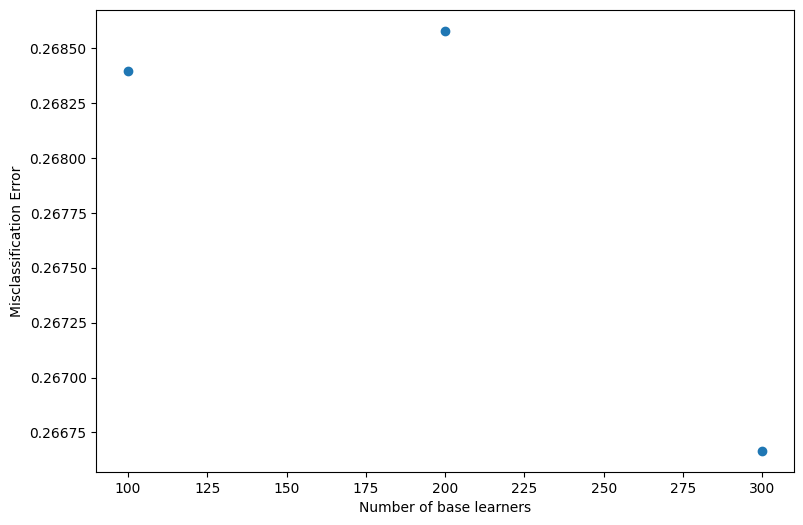

In [ ]:

# set figure size
rcParams['figure.figsize'] = 9,6
# plot the error as k-fold increases
error = [1 - x for x in cv_scores]                                              # error corresponds to each number of estimator
optimal_learners = base_ln[error.index(min(error))]                             # optimal number of n_estimator selected by minimum error
plt.scatter(base_ln, error)                                                     # plot number of estimators with corresponding misclassification error
xy = (optimal_learners, min(error))
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [ ]:
# train the best model
clf_count = RandomForestClassifier(n_estimators = optimal_learners, random_state=42)
clf_count.fit(X_train_count, y_train)
clf_count.score(X_test_count, y_test)
count_predicted = clf_count.predict(X_test_count)

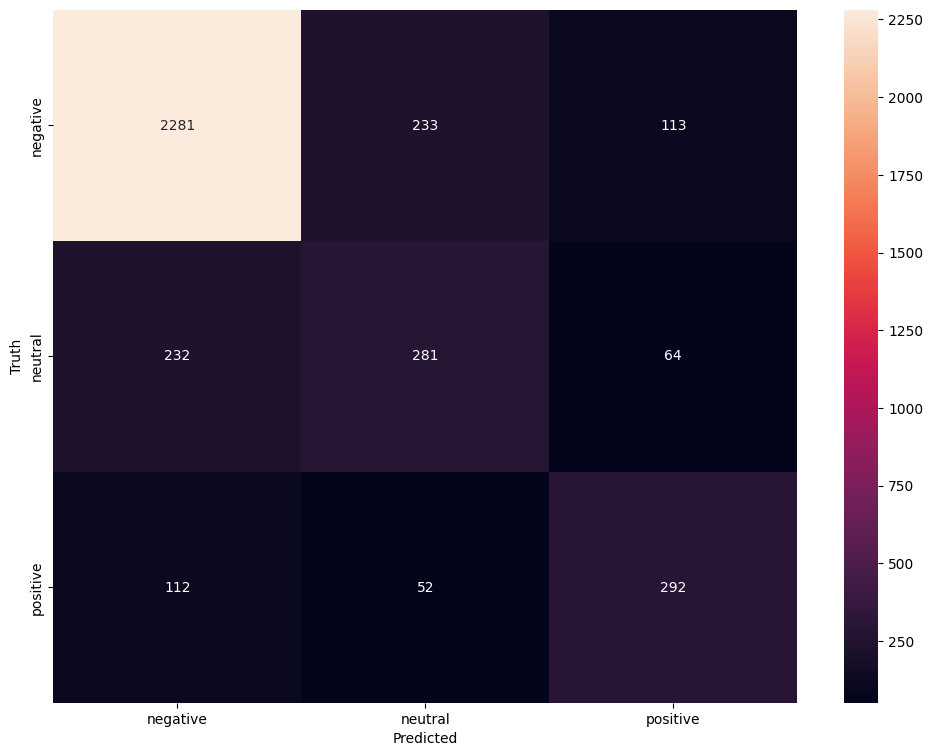

In [ ]:
from sklearn.metrics import confusion_matrix
#create confusion matrix for Count Vectorizer
cm_count=confusion_matrix(y_test,count_predicted)

plt.figure(figsize=(12,9))
sns.heatmap(cm_count,annot=True,fmt='d',xticklabels=targets , yticklabels= targets)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()
#The model is classifying 2,271 out of 2,627 negative tweets correctly (86%), 282 out of 577 neutral tweets correctly (49%), and 293 out of 456 positive tweets correctly (64%)

In [ ]:
all_features_count = count_vec.get_feature_names_out()                              # instantiate the features from the vectorizer
top_features_count=''                                                           # addition of top 40 features into top_feature after training the model
feat=clf_count.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    top_features_count+=all_features_count[i]
    top_features_count+=', '

top_features_count

'thank, delay, great, love, hours, hold, cancel, bag, awesome, get, hour, amaze, best, fly, wait, would, worst, please, time, plane, service, help, customer, fleek, call, make, go, never, lose, late, still, need, miss, flight, say, try, luggage, hrs, one, good, '

In [ ]:
# saving variables for model
y_train_count = y_train
y_test_count = y_test

In [ ]:
#Tf-Idf Vectorizer.
# set the max number of features at 1000
tfidf_vec = TfidfVectorizer(max_features=1000)
# convert test to numbers with TfidfVectorizer
data_features_idf = tfidf_vec.fit_transform(df_model['text'])
# convert the data features to array
data_features_idf = data_features_idf.toarray()

In [ ]:
# show shape of the feature vector
data_features_idf.shape

(14640, 1000)

In [ ]:
# split data into training and testing set
X_idf = data_features_idf
y = df_model.airline_sentiment
X_train_idf, X_test_idf, y_train, y_test = train_test_split(X_idf, y, test_size=0.25, shuffle=False, random_state=42)

In [ ]:
# find the optimal number of base learners using k-fold cross-validation (CV)
base_ln = np.arange(100,400,100).tolist()

# train model with k-fold CV
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, X_train_idf, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

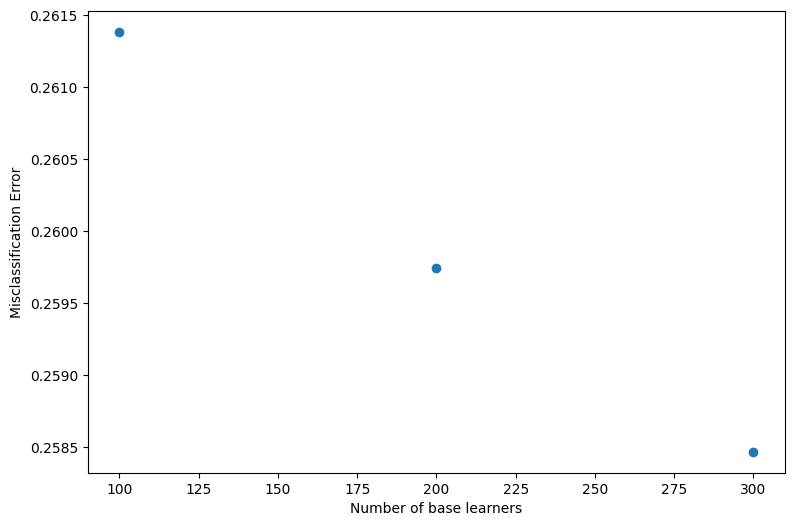

In [ ]:
# plot the error as k-fold increases
error = [1 - x for x in cv_scores]                                              # error corresponds to each number of estimator
optimal_learners = base_ln[error.index(min(error))]                             # optimal number of n_estimator selected by minimum error
plt.scatter(base_ln, error)                                                     # plot number of estimators with corresponding misclassification error
xy = (optimal_learners, min(error))
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [ ]:
# train the best model
clf = RandomForestClassifier(n_estimators = optimal_learners, random_state=42)
clf.fit(X_train_idf, y_train)
clf.score(X_test_idf, y_test)
tf_idf_predicted = clf.predict(X_test_idf)

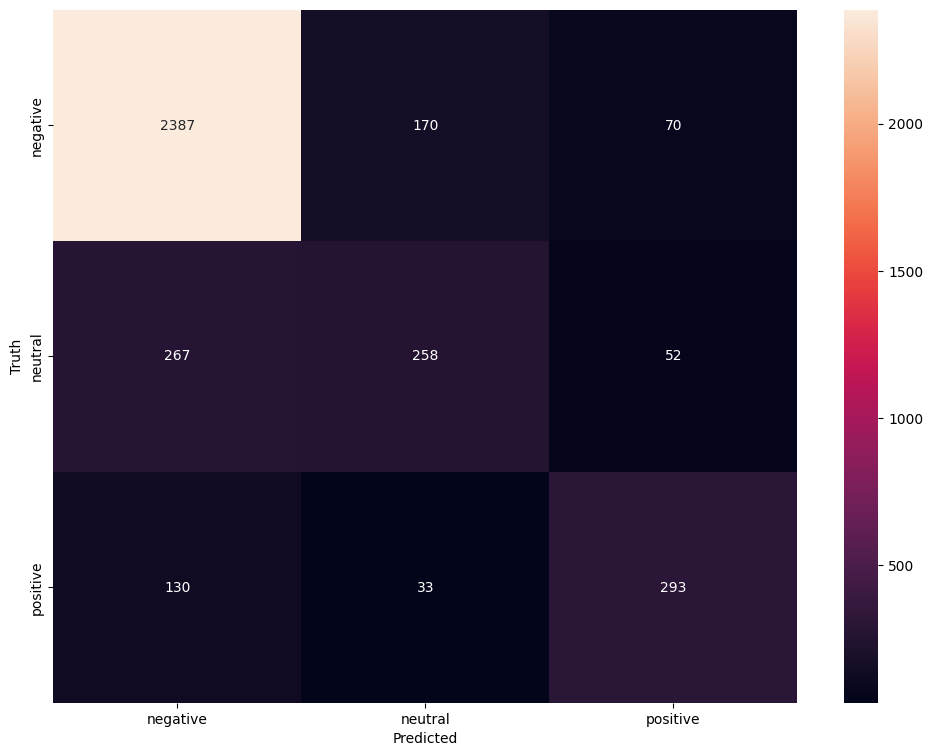

In [ ]:
# create confusion matrix for TF-IDF Vectorizer
cm_tfidf=confusion_matrix(y_test , tf_idf_predicted)

plt.figure(figsize=(12,9))
sns.heatmap(cm_tfidf,annot=True,fmt='d',xticklabels=targets , yticklabels=targets)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()
#The model is classifying 2,400 out of 2,627 negative tweets correctly (91%), 256 out of 577 neutral tweets correctly (44%), and 294 out of 456 positive tweets correctly (64%)

In [ ]:
all_features = tfidf_vec.get_feature_names_out()                                    # instantiate the features from the vectorizer
top_features=''                                                                 # addition of top 40 features into top_feature after training the model
feat=clf.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    top_features+=all_features[i]
    top_features+=', '

top_features

'thank, delay, great, love, hours, cancel, hold, get, awesome, bag, best, hour, amaze, fly, please, service, fleek, time, fleet, would, wait, make, plane, call, dm, good, follow, flight, need, customer, worst, help, airline, know, say, go, still, never, lose, late, '

In [ ]:
# saving variables for model
y_train_idf = y_train
y_test_idf = y_test

In [ ]:
#Recurring Neural Network
import numpy as np
#!pip install tensorflow
#!pip install keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from sklearn.preprocessing import LabelEncoder

In [ ]:
text_corpus = df_model.text
labels_corpus = df_model.airline_sentiment

X_train, X_test, y_train, y_test = train_test_split(text_corpus, labels_corpus, test_size=0.25, random_state=42)

In [ ]:
# set hyperparameters
num_words=4000
maxlen=1000

In [ ]:
# vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=num_words, char_level=False)

tokenizer.fit_on_texts(X_train)

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

len(sequences_train)

10980

In [ ]:
# pad sequences with 0s
X_train = pad_sequences(sequences_train, maxlen=maxlen)
X_test = pad_sequences(sequences_test, maxlen=maxlen)

print('Shape of data tensor:', X_train.shape)
print('Shape of data test tensor:', X_test.shape)
print(type(X_train))


Shape of data tensor: (10980, 1000)
Shape of data test tensor: (3660, 1000)
<class 'numpy.ndarray'>


In [ ]:
# encode target variable
label_encoder = LabelEncoder()
y_train_label = label_encoder.fit_transform(y_train)
y_test_label = label_encoder.fit_transform(y_test)

In [ ]:
#Defining the model
from keras import backend
import tensorflow as tf
backend.clear_session()

# set the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [ ]:

def create_model(maxlen,num_words,num_categories):

    model = Sequential()

    model.add(Embedding(num_words,output_dim=100,input_length=maxlen,trainable=True))

    model.add(BatchNormalization())

    model.add(Bidirectional(LSTM(100)))

    model.add(Dropout(0.2))

    model.add(Dense(128,activation='relu'))

    model.add(BatchNormalization())

    model.add(Dense(64,activation='relu'))

    model.add(Dropout(0.2))

    model.add(Dense(32,activation='relu'))

    model.add(Dense(num_categories, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

    model.summary()
    return model

In [ ]:
model=create_model(maxlen,num_words,df_model.airline_sentiment.nunique())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         400000    
                                                                 
 batch_normalization (Batch  (None, 1000, 100)         400       
 Normalization)                                                  
                                                                 
 bidirectional (Bidirection  (None, 200)               160800    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 128)               25728     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               5

In [ ]:
history = model.fit(X_train, y_train_label, epochs=5, validation_split=0.25)

Epoch 1/5
258/258 [==============================] - 59s 165ms/step - loss: 0.7643 - accuracy: 0.6793 - val_loss: 0.9095 - val_accuracy: 0.5479
Epoch 2/5
258/258 [==============================] - 22s 84ms/step - loss: 0.5375 - accuracy: 0.7917 - val_loss: 0.6209 - val_accuracy: 0.7413
Epoch 3/5
258/258 [==============================] - 21s 83ms/step - loss: 0.4038 - accuracy: 0.8472 - val_loss: 0.6423 - val_accuracy: 0.7494
Epoch 4/5
258/258 [==============================] - 22s 84ms/step - loss: 0.2995 - accuracy: 0.8861 - val_loss: 1.0927 - val_accuracy: 0.6619
Epoch 5/5
258/258 [==============================] - 20s 79ms/step - loss: 0.2456 - accuracy: 0.9077 - val_loss: 0.9320 - val_accuracy: 0.7319


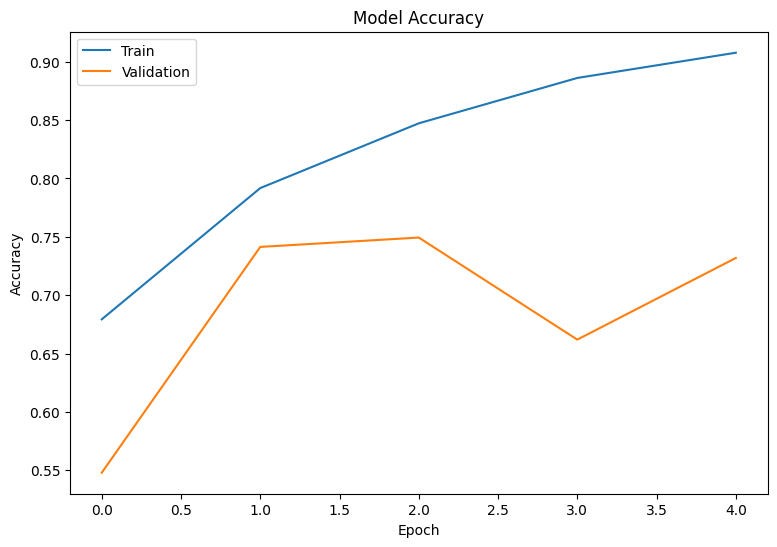

In [ ]:
#Model evaluation on training data
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
#Model evaluation on test data
accuracy = model.evaluate(X_test, y_test_label, verbose=2)

115/115 - 3s - loss: 0.9153 - accuracy: 0.7309 - 3s/epoch - 27ms/step


In [ ]:
#creating a dictionary to map model predictions to each sentiment
class_dict = {0:'negative',
 1:'neutral',
 2:'positive'}

In [ ]:
#making predictions on the test data
y_pred_test = model.predict(X_test)

#converting probabilities to class labels
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

#calculating the probability of the predicted class
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

115/115 [==============================] - 4s 24ms/step


In [ ]:
#creating a dataframe of model predictions
df = pd.DataFrame({"Labels":y_pred_test_classes})

#replacing predictions with sentiments
label_df = df.replace({"Labels":class_dict})

#converting dataframe to array
y_pred_test_classes = label_df.to_numpy()

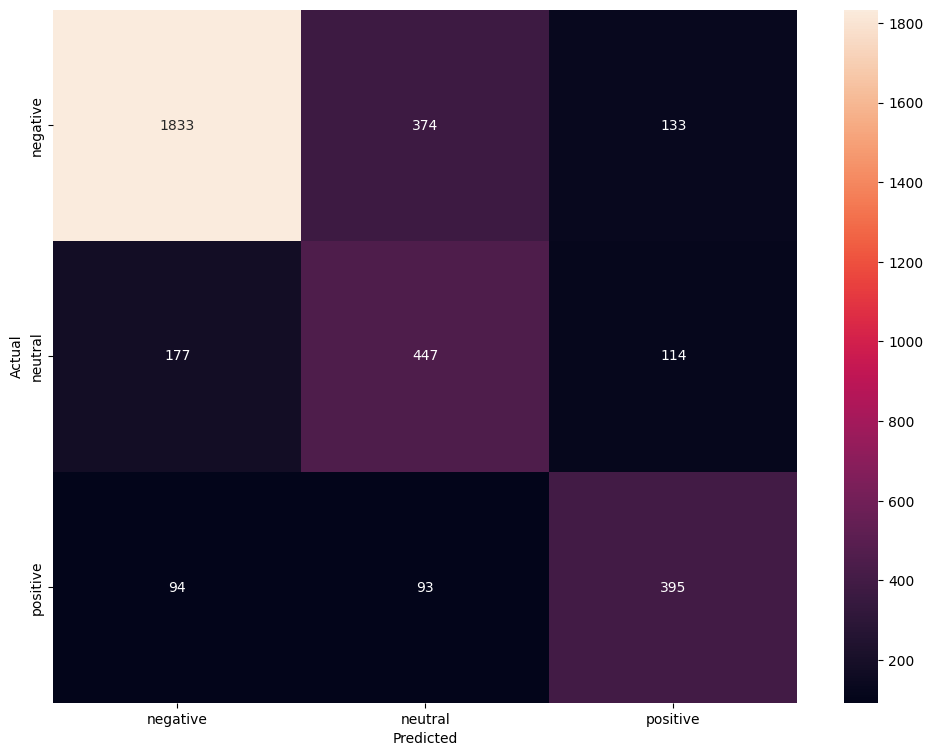

In [ ]:
#plotting the heatmap using confusion matrix
cm_rnn = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(12,9))
sns.heatmap(cm_rnn, annot=True,  fmt='.0f', xticklabels=targets, yticklabels=targets)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
#The model is classifying 1,961 out of 2,340 negative tweets correctly (84%), 411 out of 738 neutral tweets correctly (56%), and 395 out of 582 positive tweets correctly (68%)

In [ ]:
#Conclusion
# provide a classification report on the Count Vectorizer model
print("Random Forest model trained with Count Vectorizer data")
print(" ")
print(classification_report(y_test_count , count_predicted, target_names = targets))
print(" ")

# provide a classification report on the TF-IDF Vectorizer model
print("Random Forest model trained with TF-IDF Vectorizer data")
print(" ")
print(classification_report(y_test_idf , tf_idf_predicted, target_names = targets))
print(" ")

# provide the classification report on the RNN model
print("Recurring Neural Network (RNN) model")
print(" ")
print(classification_report(y_test, y_pred_test_classes))


Random Forest model trained with Count Vectorizer data
 
              precision    recall  f1-score   support

    negative       0.87      0.87      0.87      2627
     neutral       0.50      0.49      0.49       577
    positive       0.62      0.64      0.63       456

    accuracy                           0.78      3660
   macro avg       0.66      0.67      0.66      3660
weighted avg       0.78      0.78      0.78      3660

 
Random Forest model trained with TF-IDF Vectorizer data
 
              precision    recall  f1-score   support

    negative       0.86      0.91      0.88      2627
     neutral       0.56      0.45      0.50       577
    positive       0.71      0.64      0.67       456

    accuracy                           0.80      3660
   macro avg       0.71      0.67      0.68      3660
weighted avg       0.79      0.80      0.80      3660

 
Recurring Neural Network (RNN) model
 
              precision    recall  f1-score   support

    negative       0.87  

In [ ]:
#We created three classification models to predict the sentiments of tweets pertaining to one of six airlines
#The Random Forest classification model trained on data transfored from text into numbers through a TF-IDF vectorizer appears to perform the best, both in terms of overall accuracy and F1-scores across all three classes
#Given our analysis, each airline should understand which parts of the customer experience are most likely to drive positive and negative outcomes
#Additionally, given these models, each airline should be able to react to tweets with negative sentiment far quicker than through tradtional survey methods, potentially preventing or mitigating these daily occurences from materially harming their overall businesses

Shape of data tensor: (10980, 1000)
Shape of data test tensor: (3660, 1000)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 100)         400000    
                                                                 
 batch_normalization_2 (Bat  (None, 1000, 100)         400       
 chNormalization)                                                
                                                                 
 bidirectional_1 (Bidirecti  (None, 200)               160800    
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               25728     
                                            

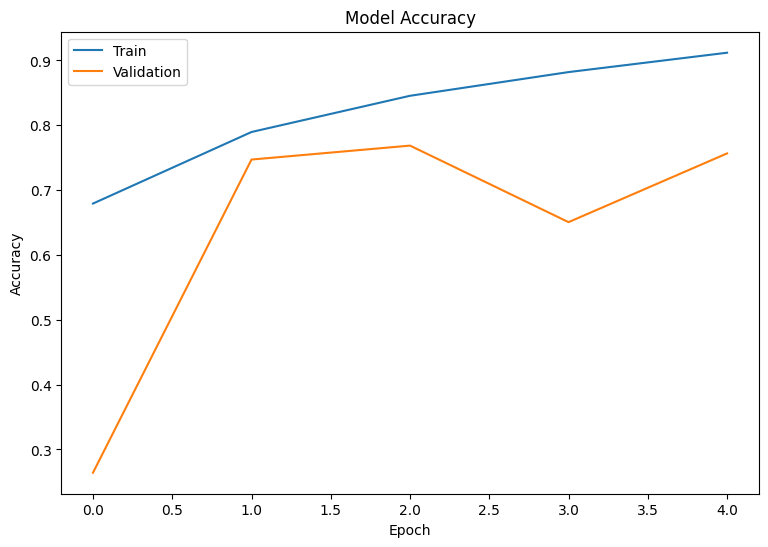

115/115 - 3s - loss: 0.8712 - accuracy: 0.7571 - 3s/epoch - 24ms/step
115/115 [==============================] - 3s 24ms/step


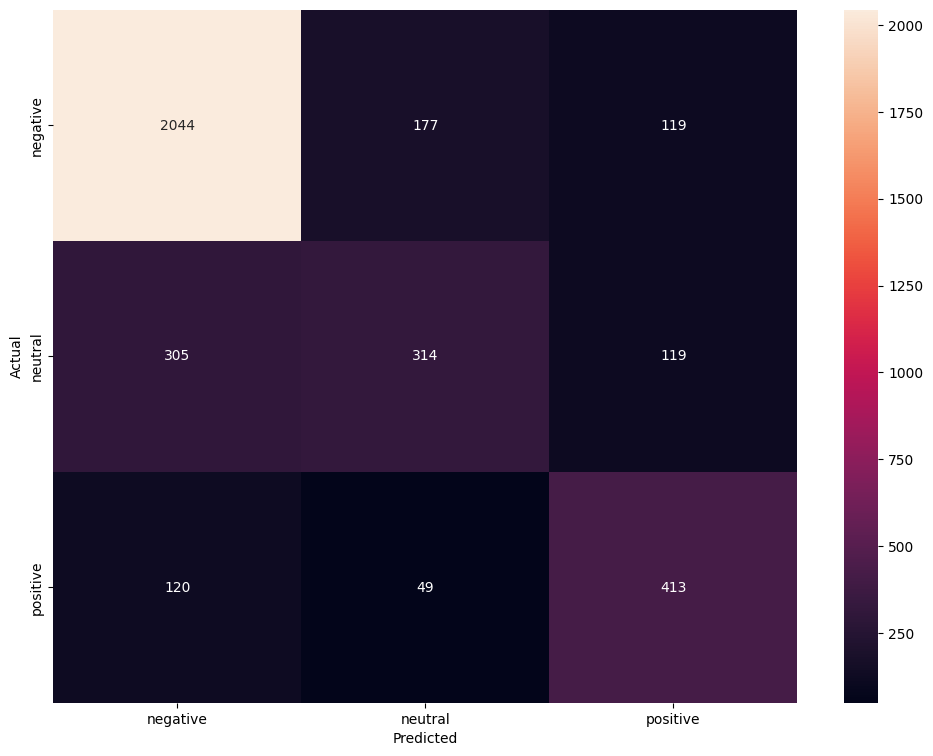

Recurring Neural Network (LSTM) model
              precision    recall  f1-score   support

    negative       0.83      0.87      0.85      2340
     neutral       0.58      0.43      0.49       738
    positive       0.63      0.71      0.67       582

    accuracy                           0.76      3660
   macro avg       0.68      0.67      0.67      3660
weighted avg       0.75      0.76      0.75      3660



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout, BatchNormalization

# Assuming df_model contains 'text' and 'airline_sentiment' columns

text_corpus = df_model['text']
labels_corpus = df_model['airline_sentiment']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(text_corpus, labels_corpus, test_size=0.25, random_state=42)

# Set hyperparameters
num_words = 4000  # Number of words to consider as features
maxlen = 1000  # Max length of each sequence

# Tokenize the text
tokenizer = Tokenizer(num_words=num_words, char_level=False)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

# Pad sequences with zeros
X_train = pad_sequences(sequences_train, maxlen=maxlen)
X_test = pad_sequences(sequences_test, maxlen=maxlen)

print('Shape of data tensor:', X_train.shape)
print('Shape of data test tensor:', X_test.shape)

# Encode target variable
label_encoder = LabelEncoder()
y_train_label = label_encoder.fit_transform(y_train)
y_test_label = label_encoder.transform(y_test)

# Define the LSTM model function
def create_lstm_model(maxlen, num_words, num_categories):
    model = Sequential()
    model.add(Embedding(num_words, output_dim=100, input_length=maxlen, trainable=True))
    model.add(BatchNormalization())
    model.add(Bidirectional(LSTM(100)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_categories, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Create the LSTM model
lstm_model = create_lstm_model(maxlen, num_words, len(df_model['airline_sentiment'].unique()))

# Train the model
history = lstm_model.fit(X_train, y_train_label, epochs=5, validation_split=0.25)

# Plotting training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model on test data
accuracy = lstm_model.evaluate(X_test, y_test_label, verbose=2)

# Make predictions on test data
y_pred_test = lstm_model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

# Mapping predictions to sentiment labels
class_dict = {0: 'negative', 1: 'neutral', 2: 'positive'}
y_pred_test_classes = [class_dict[pred] for pred in y_pred_test_classes]

# Generate confusion matrix
cm_lstm = confusion_matrix(y_test, y_pred_test_classes)

# Plotting confusion matrix
plt.figure(figsize=(12, 9))
sns.heatmap(cm_lstm, annot=True, fmt='.0f', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Classification report
print("Recurring Neural Network (LSTM) model")
print(classification_report(y_test, y_pred_test_classes))


Shape of data tensor: (10980, 1000)
Shape of data test tensor: (3660, 1000)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1000, 100)         400000    
                                                                 
 batch_normalization_4 (Bat  (None, 1000, 100)         400       
 chNormalization)                                                
                                                                 
 bidirectional_2 (Bidirecti  (None, 200)               160800    
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 200)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               25728     
                                            

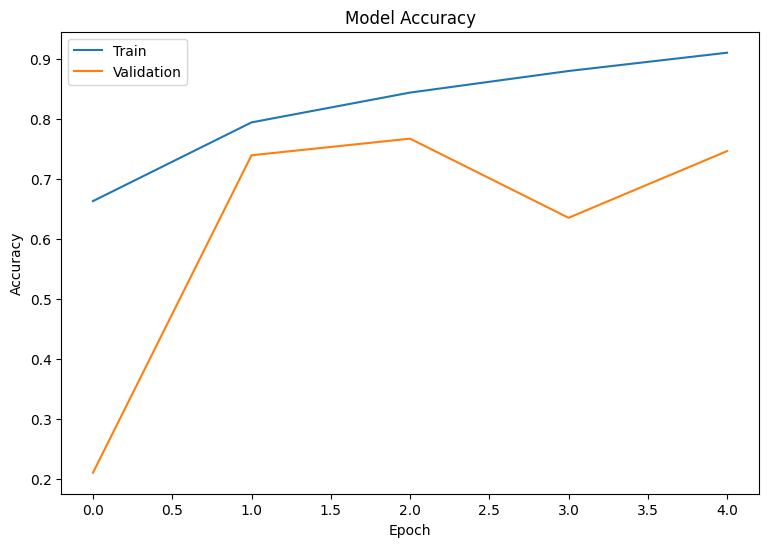

115/115 - 3s - loss: 0.8569 - accuracy: 0.7563 - 3s/epoch - 24ms/step
115/115 [==============================] - 3s 23ms/step


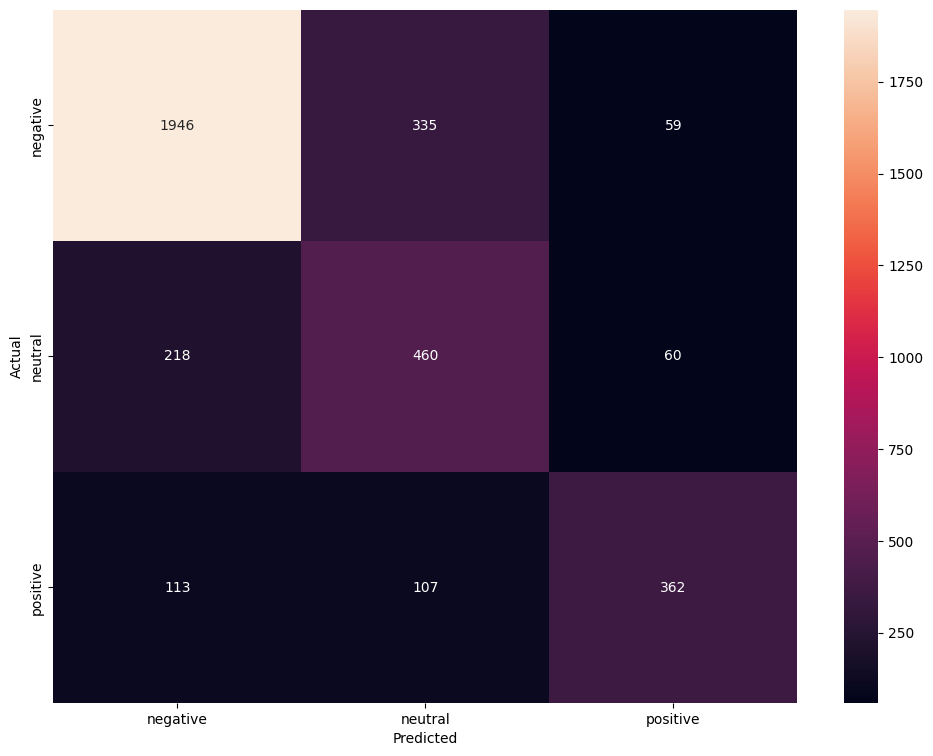

Bidirectional LSTM (BiLSTM) model
              precision    recall  f1-score   support

    negative       0.85      0.83      0.84      2340
     neutral       0.51      0.62      0.56       738
    positive       0.75      0.62      0.68       582

    accuracy                           0.76      3660
   macro avg       0.71      0.69      0.70      3660
weighted avg       0.77      0.76      0.76      3660



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout, BatchNormalization

# Assuming df_model contains 'text' and 'airline_sentiment' columns

text_corpus = df_model['text']
labels_corpus = df_model['airline_sentiment']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(text_corpus, labels_corpus, test_size=0.25, random_state=42)

# Set hyperparameters
num_words = 4000  # Number of words to consider as features
maxlen = 1000  # Max length of each sequence

# Tokenize the text
tokenizer = Tokenizer(num_words=num_words, char_level=False)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

# Pad sequences with zeros
X_train = pad_sequences(sequences_train, maxlen=maxlen)
X_test = pad_sequences(sequences_test, maxlen=maxlen)

print('Shape of data tensor:', X_train.shape)
print('Shape of data test tensor:', X_test.shape)

# Encode target variable
label_encoder = LabelEncoder()
y_train_label = label_encoder.fit_transform(y_train)
y_test_label = label_encoder.transform(y_test)

# Define the BiLSTM model function
def create_bilstm_model(maxlen, num_words, num_categories):
    model = Sequential()
    model.add(Embedding(num_words, output_dim=100, input_length=maxlen, trainable=True))
    model.add(BatchNormalization())
    model.add(Bidirectional(LSTM(100)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_categories, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Create the BiLSTM model
bilstm_model = create_bilstm_model(maxlen, num_words, len(df_model['airline_sentiment'].unique()))

# Train the model
history = bilstm_model.fit(X_train, y_train_label, epochs=5, validation_split=0.25)

# Plotting training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model on test data
accuracy = bilstm_model.evaluate(X_test, y_test_label, verbose=2)

# Make predictions on test data
y_pred_test = bilstm_model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

# Mapping predictions to sentiment labels
class_dict = {0: 'negative', 1: 'neutral', 2: 'positive'}
y_pred_test_classes = [class_dict[pred] for pred in y_pred_test_classes]

# Generate confusion matrix
cm_bilstm = confusion_matrix(y_test, y_pred_test_classes)

# Plotting confusion matrix
plt.figure(figsize=(12, 9))
sns.heatmap(cm_bilstm, annot=True, fmt='.0f', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Classification report
print("Bidirectional LSTM (BiLSTM) model")
print(classification_report(y_test, y_pred_test_classes))
